# Feature Analysis



In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

import warnings  # Base category for warnings triggered during the process of importing a module (ignored by default)
warnings.filterwarnings('ignore')  # here we prescribe the action in case of an error.

data = pd.read_csv('../data/train.csv')


In [2]:
data['Credit_History'].replace({1: 'Y', 0: 'N'}, inplace=True)
data['Credit_History'] = data['Credit_History'].fillna('DK')
data['Married'] = data['Married'].fillna('DK')
data['Gender'] = data['Gender'].fillna('DK')
data['Self_Employed'] = data['Self_Employed'].fillna('DK')
data = data[~(data['Loan_Amount_Term'] == 84)].copy()
data['Loan_Amount_Term'] = data['Loan_Amount_Term'].replace({12: 360, 36:360}) 
Loancols = [ 'LoanAmount',  'Loan_Amount_Term']
data.dropna(subset=Loancols, inplace=True)

For feature anañysis we replace the categorical target by a numerical target.

We study the relevance of the categorical variables

In [3]:
data['Loan_Status_Numeric'] = data['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

target = "Loan_Status_Numeric"
cat_vars = data.select_dtypes(include="object").columns

def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.values.sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))


cramer=[]
for var in cat_vars.drop(['Loan_ID','Loan_Status']):
    table = pd.crosstab(data[var], data[target])
    chi2, p, dof, expected = chi2_contingency(table)
    print(var)
    print("Chi-square:", chi2)
    print("p-value:", p)

    cramers_v_value = cramers_v(table)
    print("Cramer's V:", cramers_v_value)
    cramer.append([var ,cramers_v_value])



Gender
Chi-square: 1.0475631330758386
p-value: 0.5922765745014891
Cramer's V: 0.04272028651499266
Married
Chi-square: 5.977670215394508
p-value: 0.05034605030418234
Cramer's V: 0.10204929989324392
Dependents
Chi-square: 2.722049979211117
p-value: 0.43649312774799487
Cramer's V: 0.06959529654428807
Education
Chi-square: 2.306123775381754
p-value: 0.1288650508593479
Cramer's V: 0.06338483445857562
Self_Employed
Chi-square: 0.43618728962104597
p-value: 0.8040501430176571
Cramer's V: 0.02756643194306272
Credit_History
Chi-square: 160.92920979086531
p-value: 1.134138531157433e-35
Cramer's V: 0.5294945485909843
Property_Area
Chi-square: 10.007875922359167
p-value: 0.006711465401346934
Cramer's V: 0.13204288661851146


From this result, the categorical variables are important in the order:

In [4]:
list_sort = sorted(cramer, key=lambda x: x[1], reverse=True)

print("List sorted:")
for item in list_sort:
    print(f"  {item[0]}: {item[1]:.4f}")

List sorted:
  Credit_History: 0.5295
  Property_Area: 0.1320
  Married: 0.1020
  Dependents: 0.0696
  Education: 0.0634
  Gender: 0.0427
  Self_Employed: 0.0276


In fact, the really important is 'Credit_History'.

We analyse the relevance of numerical variables.

In [5]:
from sklearn.metrics import roc_auc_score


num_vars = data.select_dtypes(include=['number']).columns

for var in num_vars.drop('Loan_Status_Numeric'):
    auc = roc_auc_score(data[target], data[var])
    print(f"AUC de {var}: {auc:.3f}")
    r, p = pointbiserialr(data[target], data[var])
    print("Point biserial correlation:", r, "p-value:", p)


AUC de ApplicantIncome: 0.496
Point biserial correlation: -0.0054213171150299475 p-value: 0.8968802582726347
AUC de CoapplicantIncome: 0.516
Point biserial correlation: -0.06786118780486125 p-value: 0.10434016597085626
AUC de LoanAmount: 0.475
Point biserial correlation: -0.0401685046260143 p-value: 0.33672372279748886
AUC de Loan_Amount_Term: 0.482
Point biserial correlation: -0.0534559364507962 p-value: 0.20095485778920857


From the ROC-AUC score, all the variables have similar relevance, the incomes a little more.

From the Point biserial correlation, we can not consider the analysis due the high values of p.

## New features

To explore the capacity of pay as a relevant factor for approval of the loan, we consider three features:
* 'Income' is the sum of the applicant's income and the co-applicant's income.
* 'LoanIstallement', the quotient between the loan amount and the term of the loan, as an approximation of the loan payment
* 'IncomeImpact' is the quotient between the 'LoanInstallement' and the applicant's income, as an approximation of the percentage of income impact.

In [6]:
data['Income']=data['ApplicantIncome']+data['CoapplicantIncome']
data['LoanInstallment'] = data['LoanAmount'] / data['Loan_Amount_Term']
data['IncomeImpact'] = data['LoanInstallment']/data['ApplicantIncome']

Applyin the ROC-AUC score and the Point biserial correlation to new variables:

In [7]:
num_vars = data.select_dtypes(include=['number']).columns

for var in num_vars.drop('Loan_Status_Numeric'):
    auc = roc_auc_score(data[target], data[var])
    print(f"AUC de {var}: {auc:.3f}")
    r, p = pointbiserialr(data[target], data[var])
    print("Point biserial correlation:", r, "p-value:", p)

AUC de ApplicantIncome: 0.496
Point biserial correlation: -0.0054213171150299475 p-value: 0.8968802582726347
AUC de CoapplicantIncome: 0.516
Point biserial correlation: -0.06786118780486125 p-value: 0.10434016597085626
AUC de LoanAmount: 0.475
Point biserial correlation: -0.0401685046260143 p-value: 0.33672372279748886
AUC de Loan_Amount_Term: 0.482
Point biserial correlation: -0.0534559364507962 p-value: 0.20095485778920857
AUC de Income: 0.508
Point biserial correlation: -0.035902425970496324 p-value: 0.39058179768029344
AUC de LoanInstallment: 0.479
Point biserial correlation: -0.006173441661063429 p-value: 0.882670972861908
AUC de IncomeImpact: 0.513
Point biserial correlation: -0.07431515664617648 p-value: 0.07523254527346937


We can see that this new features has similar relevance to the originals.

### PCA

We apply PCA in order to reduce the number of numerical variables keeping the nivel of description.

In [8]:
features = ['Income', 'ApplicantIncome', 'CoapplicantIncome', 'LoanInstallment', 'LoanAmount', 'Loan_Amount_Term', 'IncomeImpact']

# Copy and scale the data
X = data[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Variance ratio explained per component:
[0.45416297 0.23600376 0.1485676  0.09109632 0.06105578 0.00911356
 0.        ]


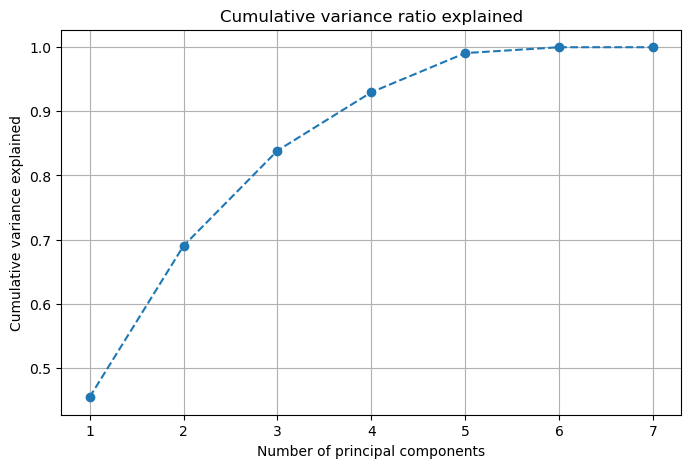

In [9]:
pca = PCA()
pca.fit(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

print("Variance ratio explained per component:")
print(explained_variance_ratio)

cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative variance ratio explained')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative variance explained')
plt.grid(True)
plt.show()

We keep 5 principal components.

In [10]:
n_components_selected = 5 
pca = PCA(n_components=n_components_selected)
X_pca = pca.fit_transform(X_scaled)

loadings = pd.DataFrame(
    pca.components_.T, 
    columns=[f'PC{i+1}' for i in range(n_components_selected)], 
    index=features
)

print("\n--- Loadings of variables ---")
print(loadings.round(3))


--- Loadings of variables ---
                     PC1    PC2    PC3    PC4    PC5
Income             0.505 -0.093  0.154 -0.486 -0.009
ApplicantIncome    0.443 -0.385  0.008 -0.396  0.271
CoapplicantIncome  0.191  0.597  0.324 -0.247 -0.585
LoanInstallment    0.499  0.049 -0.227  0.430 -0.062
LoanAmount         0.473 -0.097  0.171  0.575 -0.120
Loan_Amount_Term  -0.140 -0.234  0.884  0.174  0.147
IncomeImpact       0.142  0.648  0.089  0.039  0.738


In [11]:
n_components_selected = X_pca.shape[1] 

# List of new columns name
pca_column_names = [f'PC{i+1}' for i in range(n_components_selected)]

df_pca = pd.DataFrame(data=X_pca, columns=pca_column_names)

data = data.reset_index(drop=True)

# Join data and df_pca
data = pd.concat([data, df_pca], axis=1)


WE analyse the ROC-AUC score and the point biseral correlation for the new set of continuous variables

In [12]:
num_vars = data.select_dtypes(include=['number']).columns

for var in num_vars.drop('Loan_Status_Numeric'):
    auc = roc_auc_score(data[target], data[var])
    print(f"AUC de {var}: {auc:.3f}")
    r, p = pointbiserialr(data[target], data[var])
    print("Point biserial correlation:", r, "p-value:", p)


AUC de ApplicantIncome: 0.496
Point biserial correlation: -0.0054213171150299475 p-value: 0.8968802582726347
AUC de CoapplicantIncome: 0.516
Point biserial correlation: -0.06786118780486125 p-value: 0.10434016597085626
AUC de LoanAmount: 0.475
Point biserial correlation: -0.0401685046260143 p-value: 0.33672372279748886
AUC de Loan_Amount_Term: 0.482
Point biserial correlation: -0.0534559364507962 p-value: 0.20095485778920857
AUC de Income: 0.508
Point biserial correlation: -0.035902425970496324 p-value: 0.39058179768029344
AUC de LoanInstallment: 0.479
Point biserial correlation: -0.006173441661063429 p-value: 0.882670972861908
AUC de IncomeImpact: 0.513
Point biserial correlation: -0.07431515664617648 p-value: 0.07523254527346937
AUC de PC1: 0.490
Point biserial correlation: -0.032892712023249074 p-value: 0.43154630679071704
AUC de PC2: 0.530
Point biserial correlation: -0.052301998975365374 p-value: 0.21086452565078923
AUC de PC3: 0.491
Point biserial correlation: -0.0852589702063604